<a href="https://colab.research.google.com/github/SashankGhimire/Machine_Learning_CW/blob/main/Sentiment_Analysis_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np
import re

# ML & NLP
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report,confusion_matrix,roc_curve, auc,precision_recall_curve, average_precision_score ,ConfusionMatrixDisplay
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn.model_selection import learning_curve
#visualization
import matplotlib.pyplot as plt
import seaborn as sns


Import IMDB Dataset

In [ ]:
import kagglehub

path = kagglehub.dataset_download(
    "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews"
)

print("Dataset path:", path)

Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Dataset path: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
df = pd.read_csv(path + "/IMDB Dataset.csv")
df.head(n=10) # .head Shows First 5 Rows

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Dataset Checks

In [ ]:
df.isnull().sum() # No null Values
df["sentiment"].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [ ]:
df = df.rename(columns={
    "review": "text",
    "sentiment": "label"
})

df.head()

,text,label
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Data Preprocessing

In [ ]:
def clean_text(s):
    s = s.lower()
    s = s.replace("<br />", " ")
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


Train-Test Split

In [ ]:
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))


Training samples: 40000
Testing samples: 10000


Using the Tf-IDF vectorizer

In [ ]:
tfidf = TfidfVectorizer(
    #max_features=1000, #got accuracy of 86% and # %86
    #max_features=3000, #got accuracy of 87% on logistic regression and 87% on SVM
    max_features=5000, #got accuracy of 89% on SVM and 88% on SVM
    #max_features=10000, # nochange
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print(X_train_tfidf.shape)


(40000, 5000)


Using Logistic Regression

In [ ]:
model = LogisticRegression(
    max_iter=3000,
)

model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=3000)

Logistic Regression Evaluation

In [ ]:
lr_pred = model.predict(X_test_tfidf)
# Measures overall correctness of the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
# Measures overall correctness of the model
print("Precision:", precision_score(y_test, lr_pred, pos_label="positive"))
#how many actual positives were found
print("Recall   :", recall_score(y_test, lr_pred, pos_label="positive"))
#Balance of precision and recall
print("F1-score :", f1_score(y_test, lr_pred, pos_label="positive"))

Logistic Regression Accuracy: 0.8907
Precision: 0.8838671644723914
Recall   : 0.8996
F1-score : 0.8916641887203886


In [ ]:
print("\nLogisticRegression Report:\n")
print(classification_report(y_test, lr_pred))


LogisticRegression Report:

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Visualizations

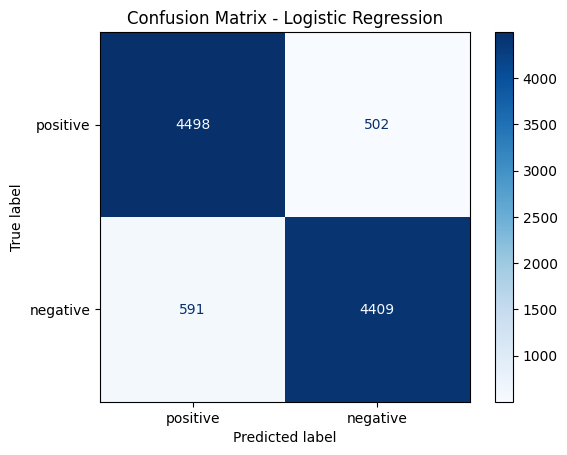

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(
    y_test,
    lr_pred,
    labels=["positive", "negative"]
)
# Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["positive", "negative"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


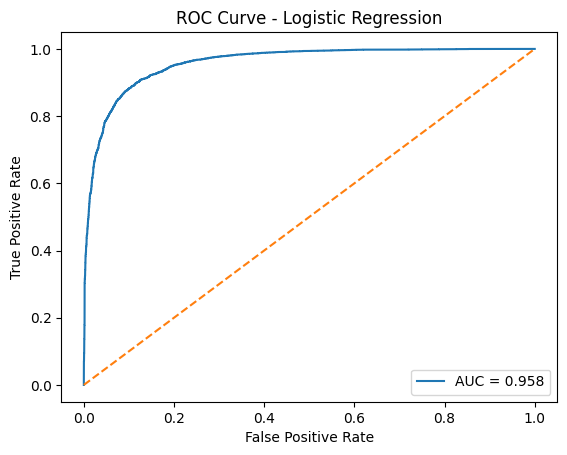

In [ ]:
# Convert sentiment labels to binary (0 = negative, 1 = positive) ROC curves require binary values
y_test_binary = y_test.map({"negative": 0, "positive": 1})#Selects the probability of the positive sentiment.

# Get probability scores for the positive class
y_scores = model.predict_proba(X_test_tfidf)[:, 1]

# Calculate False Positive Rate and True Positive Rate
#FPR (False Positive Rate) -- how often negatives are wrongly predicted as positive
#TPR (True Positive Rate) → how many positives are correctly identified
fpr, tpr, _ = roc_curve(y_test_binary, y_scores)

# Calculate Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label="AUC = " + str(round(roc_auc, 3)))
plt.plot([0, 1], [0, 1], "--")  # reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

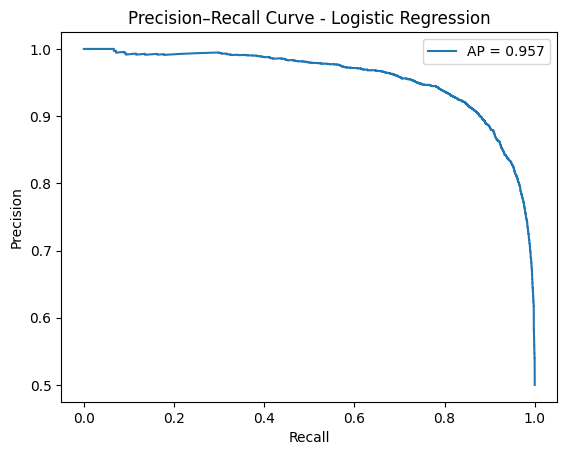

In [ ]:
# Convert labels to binary (0 = negative, 1 = positive)
y_test_binary = y_test.map({"negative": 0, "positive": 1})

# Get probability scores for the positive class
y_scores = model.predict_proba(X_test_tfidf)[:, 1]

# Calculate precision and recall values
precision, recall, _ = precision_recall_curve(y_test_binary, y_scores)

# Calculate Average Precision (AP)
avg_precision = average_precision_score(y_test_binary, y_scores)

# Plot Precision–Recall curve
plt.plot(recall, precision, label="AP = " + str(round(avg_precision, 3)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Logistic Regression")
plt.legend()
plt.show()

 Important Features and Words

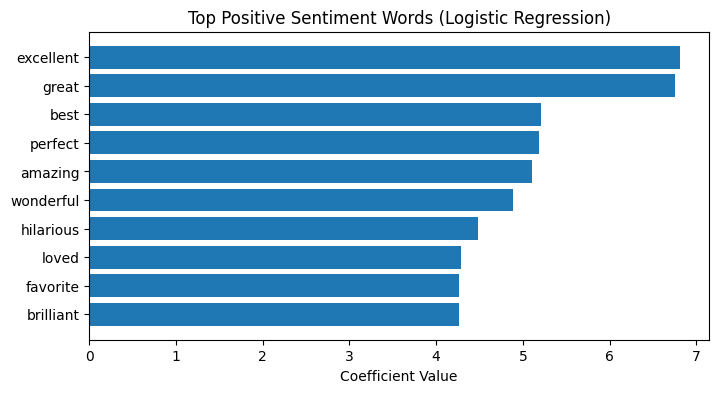

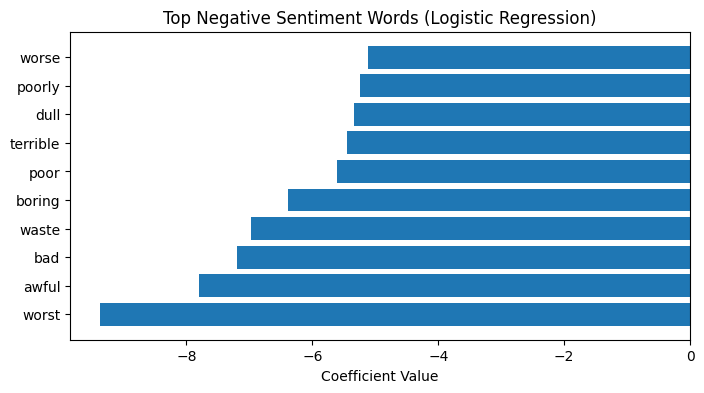

In [ ]:
# Get all word/feature names learned by TF-IDF
feature_names = np.array(tfidf.get_feature_names_out())

# Logistic Regression learns one coefficient per feature
coefficients = model.coef_[0]

# Top Positive Words
top_pos_idx = np.argsort(coefficients)[-10:]  # highest coefficients
plt.figure(figsize=(8,4))
plt.barh(feature_names[top_pos_idx], coefficients[top_pos_idx])
plt.title("Top Positive Sentiment Words (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.show()

# Top Negative Words
top_neg_idx = np.argsort(coefficients)[:10]  # lowest coefficients
plt.figure(figsize=(8,4))
plt.barh(feature_names[top_neg_idx], coefficients[top_neg_idx])
plt.title("Top Negative Sentiment Words (Logistic Regression)")
plt.xlabel("Coefficient Value")
plt.show()

Word Cloud

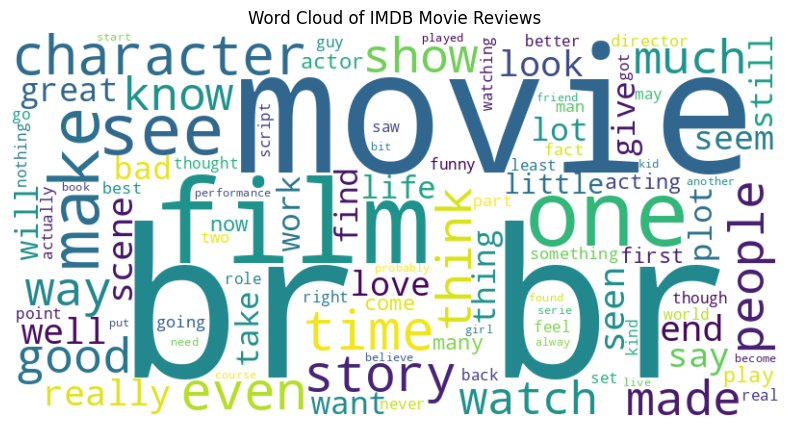

In [ ]:
# Combine all review text into one string
all_text = " ".join(df["text"])

# Create word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(all_text)

# Display word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of IMDB Movie Reviews")
plt.show()

Model in Action

In [ ]:
# New unseen sentence
sentence = "The movie was not bad" #“TF-IDF is limited because it does not capture context, negation, or semantic meaning, which can lead to misclassification of phrases like ‘not bad’ or sarcastic statements.”

# Preprocess the sentence
sentence_clean = clean_text(sentence)
sentence_tfidf = tfidf.transform([sentence_clean])

# Convert sentence to TF-IDF
sentence_tfidf = tfidf.transform([sentence])

# Predict sentiment label
prediction = model.predict(sentence_tfidf)[0]

# Predict probability for positive sentiment
probability = model.predict_proba(sentence_tfidf)[0][1]

# Show result
print("Sentence:", sentence)
print("Predicted Sentiment:", prediction)
print("Positive Probability:", round(probability, 3))


Sentence: The movie was not bad
Predicted Sentiment: negative
Positive Probability: 0.035


In [ ]:
# New unseen sentence
sentence = "The movie was amazing and inspiring"

# Preprocess the sentence
sentence_clean = clean_text(sentence)
sentence_tfidf = tfidf.transform([sentence_clean])

# Convert sentence to TF-IDF
sentence_tfidf = tfidf.transform([sentence])

# Predict sentiment label
prediction = model.predict(sentence_tfidf)[0]

# Predict probability for positive sentiment
probability = model.predict_proba(sentence_tfidf)[0][1]

# Show result
print("Sentence:", sentence)
print("Predicted Sentiment:", prediction)
print("Positive Probability:", round(probability, 3))


Sentence: The movie was amazing and inspiring
Predicted Sentiment: positive
Positive Probability: 0.969


In [ ]:
# New unseen sentence
sentence = "I hated the movie and the story was very disappointing"

# Preprocess the sentence
sentence_clean = clean_text(sentence)
sentence_tfidf = tfidf.transform([sentence_clean])

# Convert sentence to TF-IDF
sentence_tfidf = tfidf.transform([sentence])

# Predict sentiment label
prediction = model.predict(sentence_tfidf)[0]

# Predict probability for positive sentiment
probability = model.predict_proba(sentence_tfidf)[0][1]

# Show result
print("Sentence:", sentence)
print("Predicted Sentiment:", prediction)
print("Positive Probability:", round(probability, 3))


Sentence: I hated the movie and the story was very disappointing
Predicted Sentiment: negative
Positive Probability: 0.034


Check Training vs Testing Accuracy to know over/under fitting

In [ ]:
# Training predictions
lr_train_pred = model.predict(X_train_tfidf)

# Training accuracy
train_acc = accuracy_score(y_train, lr_train_pred)

# Testing accuracy (already predicted earlier)
test_acc = accuracy_score(y_test, lr_pred)

print("Logistic Regression Training Accuracy:", round(train_acc, 3))
print("Logistic Regression Testing Accuracy :", round(test_acc, 3))

#The training and testing accuracies are both high
#The gap between them is small
#This indicates good generalisation


Logistic Regression Training Accuracy: 0.912
Logistic Regression Testing Accuracy : 0.891


Learning Curve – Logistic Regression

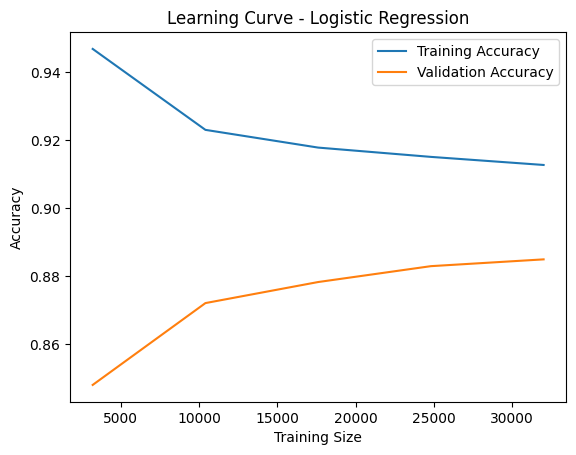

In [ ]:
# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    model,                  # Logistic Regression model
    X_train_tfidf,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean accuracy
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.show()

Using Support Vector Machine (SVM)

In [ ]:
# Initialize Linear SVM model
svm_model = LinearSVC()

# Train the model
svm_model.fit(X_train_tfidf, y_train)

LinearSVC()

In [ ]:
# Predict sentiment on test data
svm_pred = svm_model.predict(X_test_tfidf)

SVM Model Evaluation

In [ ]:
# SVM Evaluation
svm_pred = svm_model.predict(X_test_tfidf)

# Measures overall correctness of the model
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))

# Measures how many predicted positives are actually positive
print("Precision:", precision_score(y_test, svm_pred, pos_label="positive"))

# How many actual positives were found
print("Recall   :", recall_score(y_test, svm_pred, pos_label="positive"))

# Balance of precision and recall
print("F1-score :", f1_score(y_test, svm_pred, pos_label="positive"))

print("\nSVM Classification Report:\n")

# Detailed classification report
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.8817
Precision: 0.877696417969523
Recall   : 0.887
F1-score : 0.8823236844722968

SVM Classification Report:

              precision    recall  f1-score   support

    negative       0.89      0.88      0.88      5000
    positive       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



Visualizations

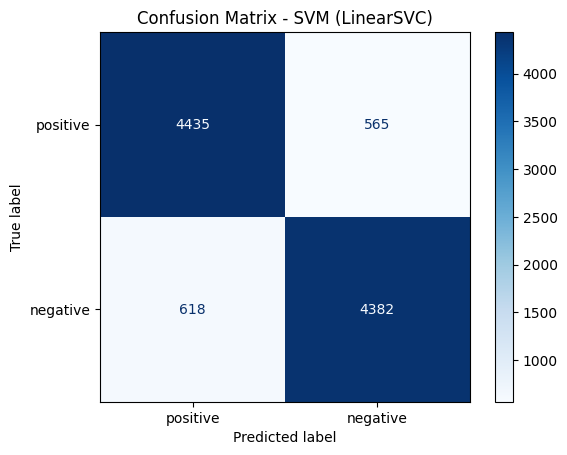

In [ ]:
# Predict using SVM
svm_pred = svm_model.predict(X_test_tfidf)

# Confusion matrix
cm_svm = confusion_matrix(y_test, svm_pred, labels=["positive", "negative"])

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                             display_labels=["positive", "negative"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - SVM (LinearSVC)")
plt.show()

Important Features and Words For SVM

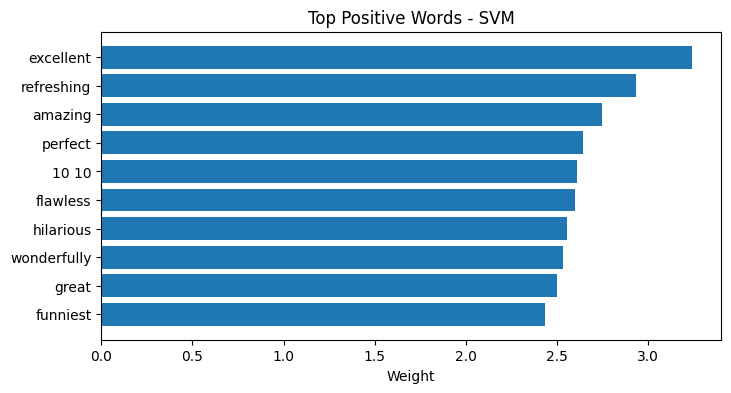

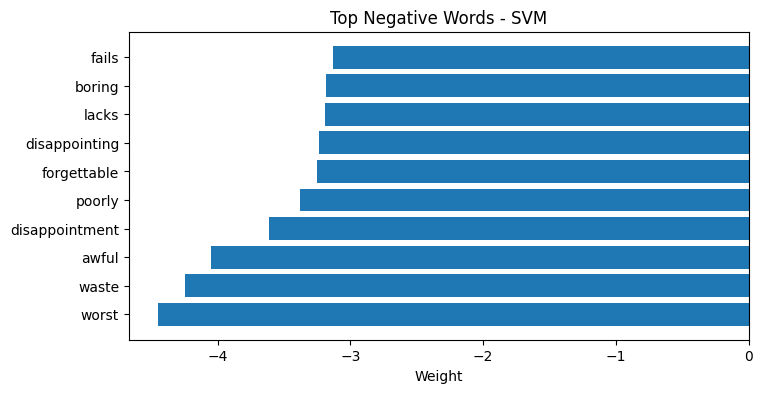

In [ ]:
feature_names = np.array(tfidf.get_feature_names_out())
coefficients = svm_model.coef_[0]

# Top positive
top_pos_idx = np.argsort(coefficients)[-10:]
plt.figure(figsize=(8,4))
plt.barh(feature_names[top_pos_idx], coefficients[top_pos_idx])
plt.title("Top Positive Words - SVM")
plt.xlabel("Weight")
plt.show()

# Top negative
top_neg_idx = np.argsort(coefficients)[:10]
plt.figure(figsize=(8,4))
plt.barh(feature_names[top_neg_idx], coefficients[top_neg_idx])
plt.title("Top Negative Words - SVM")
plt.xlabel("Weight")
plt.show()

Word Cloud

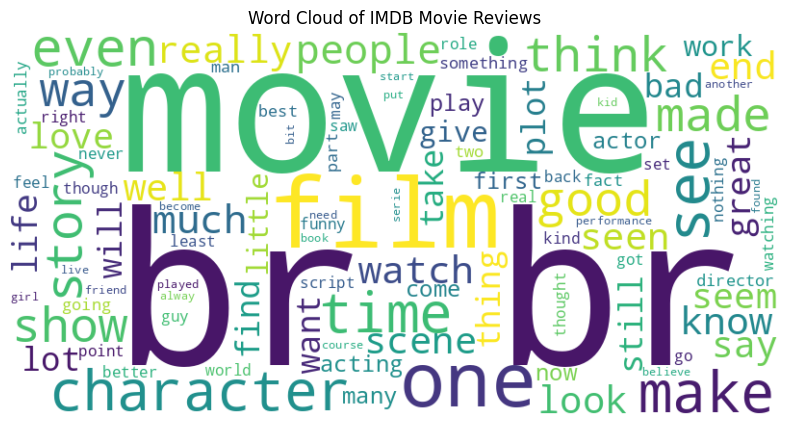

In [ ]:
# Combine all cleaned review text
all_text = " ".join(df["text"])

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=100
).generate(all_text)

# Display word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of IMDB Movie Reviews")
plt.show()

In [ ]:
#LinearSVC does not provide probabilities, (To see SVC(probability=True)
sentence = "The movie was amazing and inspiring"

sentence_clean = clean_text(sentence)
sentence_tfidf = tfidf.transform([sentence_clean])

sentence_tfidf = tfidf.transform([sentence])
svm_prediction = svm_model.predict(sentence_tfidf)[0]

print("Sentence:", sentence)
print("Predicted Sentiment (SVM):", svm_prediction)

Sentence: The movie was amazing and inspiring
Predicted Sentiment (SVM): positive


In [ ]:
sentence = "The movie was terrible and boring"

sentence_clean = clean_text(sentence)
sentence_tfidf = tfidf.transform([sentence_clean])

sentence_tfidf = tfidf.transform([sentence])
svm_prediction = svm_model.predict(sentence_tfidf)[0]

print("\nSentence:", sentence)
print("Predicted Sentiment (SVM):", svm_prediction)


Sentence: The movie was terrible and boring
Predicted Sentiment (SVM): negative


Check Training vs Testing Accuracy to know over/under fitting

In [ ]:
# Training accuracy for SVM
svm_train_pred = svm_model.predict(X_train_tfidf)
svm_train_acc = accuracy_score(y_train, svm_train_pred)

# Testing accuracy for SVM
svm_test_acc = accuracy_score(y_test, svm_pred)

print("SVM Training Accuracy:", round(svm_train_acc, 3))
print("SVM Testing Accuracy :", round(svm_test_acc, 3))
#Training accuracy is high
#Testing accuracy is noticeably lower
#The gap is larger than Logistic Regression

SVM Training Accuracy: 0.928
SVM Testing Accuracy : 0.882


Learning Curve – SVM (LinearSVC)

In [ ]:
# Generate learning curve data for SVM
train_sizes, train_scores, val_scores = learning_curve(
    svm_model,              # SVM model (LinearSVC)
    X_train_tfidf,
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

# Calculate mean accuracy for training and validation
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

# Plot learning curve
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, val_mean, label="Validation Accuracy")
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve - SVM (LinearSVC)")
plt.legend()
plt.show()

Comparing All Models Visuals

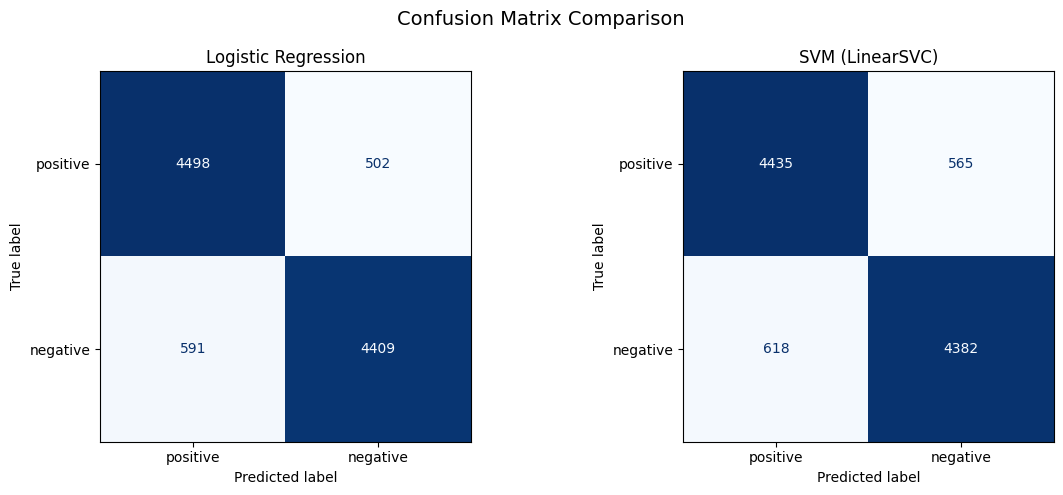

In [ ]:
cm_lr = confusion_matrix(y_test, lr_pred, labels=["positive", "negative"])
cm_svm = confusion_matrix(y_test, svm_pred, labels=["positive", "negative"])

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression
disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["positive", "negative"]
)
disp_lr.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Logistic Regression")

# SVM
disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=["positive", "negative"]
)
disp_svm.plot(ax=axes[1], cmap="Blues", colorbar=False)
axes[1].set_title("SVM (LinearSVC)")

plt.suptitle("Confusion Matrix Comparison", fontsize=14)
plt.tight_layout()
plt.show()